# 10.4 Bahdanau注意力
- **目录**
  - 10.4.1 Bahdanau注意力模型
  - 10.4.2 定义Bahdanau注意力解码器
  - 10.4.3 训练Bahdanau注意力解码器

我们在9.7节中探讨了机器翻译问题：
通过设计一个基于两个循环神经网络的编码器-解码器架构，
用于序列到序列学习。
具体来说，循环神经网络编码器将长度可变的序列转换为**固定形状的上下文变量**，


然后循环神经网络解码器根据生成的词元和上下文变量
按词元生成输出（目标）序列词元。
然而，即使**并非所有输入（源）词元对解码某个词元都有用**，
在每个解码步骤中仍使用编码**相同的上下文变量**。
有什么方法能改变上下文变量呢？

我们试着寻找灵感：
在为给定文本序列生成手写的挑战中，
Graves等人设计了一种可微注意力模型，
将文本字符与更长的笔迹对齐，
其中对齐方式仅向一个方向移动。

受**学习对齐**想法的启发，Bahdanau等人提出了一个没有严格**单向对齐**限制的可微注意力模型。
在预测词元时，如果不是所有输入词元都相关，**模型将仅对齐（或参与）输入序列中与当前预测相关的部分**。这是通过将上下文变量视为注意力集中的输出来实现的。

- **要点：**
  - 9.7节讨论了利用循环神经网络的编码器-解码器架构来解决机器翻译问题。
  - 标准模型中存在的问题是，所有输入词元不一定都与生成特定输出词元相关。
  - 采用了可微注意力机制，无单向对齐限制，关注与当前预测词元相关的输入部分。
  - 上下文变量因此变得动态，为预测每个词元关注不同的输入序列部分。

------------------
- **说明：**
- **（1）何为单向对齐和学习对齐？**
  - 在序列到序列的机器翻译任务中，编码器-解码器框架常用于将输入序列转换为输出序列。然而，这种方法存在一些挑战，尤其是在处理具有不同长度和结构的源语言和目标语言时。为此，注意力机制被引入以改善此过程。以下是关于单向对齐和学习对齐的详细解释和示例：
  - **单向对齐**
    - 单向对齐是指在处理输入和输出序列对齐时，序列的移动或匹配仅限于一个方向。典型的例子是时间序列的处理，输入序列只能向前（或向后）滑动，不能逆向或随意跳跃。
    - 在手写生成任务中，给定一个文本序列，生成对应的手写笔迹时，必须从左到右按顺序进行，不允许逆向。这种严格的顺序限制就是单向对齐。
    - **例子**：想象一个手写生成任务：你有一个文本“hello”，需要生成对应的手写。你必须从“h”开始，然后是“e”，依次生成，不能逆序或者跳跃生成任何其他字符。这种处理过程要求生成序列的方向是固定的，从左到右。
  - **学习对齐**
    - 学习对齐是指模型在生成输出序列时，不再受限于单向顺序，而是可以动态地选择最相关的输入部分进行对齐和处理。
    - Bahdanau等人提出的注意力机制允许模型在生成每个输出词元时，对输入序列的所有部分进行评估，并选择最相关的部分进行对齐。这样，模型可以在每个解码步骤中使用不同的上下文信息，而不再是固定的。
    - **例子**：
      - 在机器翻译任务中，假设你需要将英语句子“the cat is on the mat”翻译为法语句子“le chat est sur le tapis”。在传统的编码器-解码器模型中，生成每个法语词元时，都会使用相同的上下文向量。然而，很多时候，“le chat”对应“the cat”，“est”对应“is”，而“sur le tapis”对应“on the mat”，这意味着生成某个词元时只需对齐特定的输入部分。
      - 使用学习对齐，模型在翻译“le chat”时，重点关注输入的“the cat”部分；在翻译“est”时，它会关注“is”；在翻译“sur le tapis”时，它会重点关注“on the mat”。这种动态调整使得注意力机制能够在每个时间步聚焦于不同的输入片段，从而提高翻译的准确性和流畅性。
  - 总结：
    - **单向对齐**是一种严格的、顺序性的对齐方式，限制了序列的处理方向。
    - **学习对齐**利用注意力机制使模型能够动态选择最相关的输入部分进行对齐，消除了单向对齐的限制，提高了模型的灵活性和翻译质量。
   
----------------

## 10.4.1 Bahdanau注意力模型

- 下文中的Bahdanau注意力模型
将遵循与9.7节中的相同符号表达。
- 这个新的基于注意力的模型与9.7节中的模型相同，
只不过公式9.7.3中的上下文变量$\mathbf{c}$
在任何解码时间步$t'$都会被$\mathbf{c}_{t'}$替换。
- 假设输入序列中有$T$个词元，
**解码时间步$t'$的上下文变量是注意力池化的输出**：
$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t \tag{10.4.1}$$
  - 其中，时间步$t' - 1$时的解码器隐状态$\mathbf{s}_{t' - 1}$是查询，
  - 编码器隐状态$\mathbf{h}_t$既是键，也是值，
  - 注意力权重$\alpha$是使用公式10.3.2
所定义的加性注意力打分函数计算的。
- 与图9.7.2中的循环神经网络编码器-解码器架构略有不同， 图10.4.1描述了Bahdanau注意力的架构。

<center><img src='../img/seq2seq-attention-details.svg'></center>
<center>图10.4.1 一个带有Bahdanau注意力的循环神经网络编码器-解码器模型</center>

In [1]:
%matplotlib inline
import torch

from torch import nn
from d2l import torch as d2l

## 10.4.2 定义Bahdanau注意力解码器

- 下面看看如何定义Bahdanau注意力，实现循环神经网络编码器-解码器。
- 其实只需重新定义解码器即可。
- 为了更方便地显示学习的注意力权重，
以下`AttentionDecoder`类定义了**带有注意力机制解码器的基本接口**。


In [2]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

- 在接下来的`Seq2SeqAttentionDecoder`类中
**实现带有Bahdanau注意力的循环神经网络解码器**。
- 首先初始化解码器的状态，需要下面的输入：
  - <b>编码器在所有时间步的最终层隐状态，将作为注意力的键和值；</b>
  - <b>上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；</b>
  - <b>编码器有效长度（排除在注意力池中填充词元）</b>。
- 在每个解码时间步骤中，**解码器上一个时间步的最终层隐状态将用作查询**。
- 因此，注意力输出和输入嵌入都连结为循环神经网络解码器的输入。

In [4]:
## 测试版Decoder
class Seq2SeqAttentionDecoder(AttentionDecoder):
    '''
    参数：10, 8, 16, 2     
    '''
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        '''
        Q: 解码器上一个时间步t'-1的隐状态s_t'-1
        K和V: 编码器的输出的隐状态ht
        参数:16, 16, 16, 0.1
        返回值形状： (batch_size, no. of key-value pairs, value dimension)
        '''
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        
        ## 参数值分别为：10, 8
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        ## 注意python的一些特点，此处是构造函数，里面的参数是初始化参数。
        ## 在__init__()函数里使用。
        ## 参数：8+16, 16, 2, 0.1
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        ## 参数：16, 10
        self.dense = nn.Linear(num_hiddens, vocab_size)

    '''
    enc_outputs参数是编码器的输出。
    '''
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        '''
        enc_outputs是编码器的输出， 然后对其拆箱成两个变量：
        outputs: (7, 4, 16)和hidden_state:(2,4,16)
        
        在函数return时又将outputs进行了重排，变形成(4,7,16)，
        
        '''
        outputs, hidden_state = enc_outputs     
        print('init_state内部-outputs,hidden_state:', outputs.shape,hidden_state.shape)
        ## 返回值：(4, 7, 16),(2, 4, 16), enc_valid_lens
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size, num_hiddens)        
        '''
        此处的state是外部调用init_state函数后的返回值，然后传递进来的。
        注意此处的enc_outputs不要与init_state函数的参数enc_outputs弄混,
        此处的enc_outputs只是init_state中的outputs。    
        
        enc_outputs: (4, 7, 16)
        hidden_state: (2, 4, 16)
        '''
        ## enc_outputs形状：(batch_size，num_steps，num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        print('forward时的enc_outputs, hidden_state：',enc_outputs.shape, hidden_state.shape)
        
        # 输出X的形状为(num_steps,batch_size,embed_size)
        '''
        X变形成：(7, 4, 8).
        嵌入层大小为8
        '''
        X = self.embedding(X).permute(1, 0, 2)
        print("X的形状：", X.shape)
        outputs, self._attention_weights = [], []
        
        ## 是在序列(时间步)上进行迭代
        for x in X:
            
            # query的形状为(batch_size,1,num_hiddens)
            '''
            query是hidden_state的最上一层的输出隐状态。
            hidden_state是(2,4,16),hidden_state[-1]的形状是(4,16)
            unsqueeze后是(4,1,16)
            '''
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            print('query shape:', query.shape)
            # context的形状为(batch_size,1,num_hiddens)
            '''
            此处的context是通过注意力机制计算得到的，
            和以往的上下文向量(固定值)有所不同。
            
            参数：
            enc_outputs：(4,7,16)
            输出：
            context：(4,1,16)            
            '''
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            print('context shape:', context.shape)
            # 在特征维度上连结
            '''
            每次迭代的x形状为(4,8)，然后在第2轴上unsqueeze，变成(4,1,8);
            然后再与context在-1维（最后一维），即矩阵在水平方向进行拼接，变成(4,1,24)，
            其目的是将上下文向量(注意力)附加到输入的X上。
            '''
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            print('连接操作之后的x形状：', x.shape)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)            
            '''
            (1) 注意: 这里的hidden_state初始值由编码器传递过来，
                需要在每次迭代时更新，作为下一个时间步的st'-1.
            (2) enc_outputs：固定不更新，它是编码器那边计算并输出的隐状态。
            (3) out：本例的rnn是一个GRU，在batch_first为False的情况下(默认值是False，本例采用默认值)，
                一般是按照(L, N, H)的形状输入。输出的形状也是(L, N, H)，
                如果是双向的rnn，那么输出层的H轴要*D，即(L,N,D*H)。
                L: 序列长度(或时间步数)，N：批量大小，H：隐状态单元数（或隐藏层单元数）。            
            返回值：
            out: (1,4,16)
            hidden_state: (2, 4, 16)
            '''
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            
            '''
            outputs形状：[7*(1, 4, 16)]
            '''
            outputs.append(out)            
            self._attention_weights.append(self.attention.attention_weights)
        '''
        torch.cat(outputs, dim=0)将outputs从[7*(1, 4, 16)]连接成(7, 4, 16)，然后再参与全连接层计算
        # 全连接层变换后，outputs的形状为:(num_steps,batch_size,vocab_size).
        原注释有误导性：
        (1) outputs = self.dense(torch.cat(outputs, dim=0))这一句是在num_steps时间步上进行迭代，
        然后在在纵向上进行连接；
        (2) 将所有的时间步的输出连接完之后，再进行重排，将小批量重排到前面第1维，时间步重排到第2维。
        (3) ouputs:(7,4,10)->(4,7,10)
        (4)第二个返回值是下面代码中用到的state，包含所有时间步的隐状态；最后一个时间步的隐状态以及有效长度向量。
        '''
        outputs = self.dense(torch.cat(outputs, dim=0))
        print('全连接层输出outputs:', outputs.shape)
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

- Bahdanau注意力解码器对照说明
<img src='../img/10_4_1.png' >

- 接下来使用包含7个时间步的4个序列输入的小批量**测试Bahdanau注意力解码器**。


In [5]:
'''
# `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
# `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
编码器的2个输出：
(7, 4, 16) 和 (2, 4, 16)
'''
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
## 在此初始化解码器的输入状态
## 注意：enc_valid_lens参数为空
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
## state包含了3个张量的list
output.shape, len(state), state[0].shape, state[1].shape,len(state[1])

init_state内部-outputs,hidden_state: torch.Size([7, 4, 16]) torch.Size([2, 4, 16])
forward时的enc_outputs, hidden_state： torch.Size([4, 7, 16]) torch.Size([2, 4, 16])
X的形状： torch.Size([7, 4, 8])
query shape: torch.Size([4, 1, 16])
context shape: torch.Size([4, 1, 16])
连接操作之后的x形状： torch.Size([4, 1, 24])
query shape: torch.Size([4, 1, 16])
context shape: torch.Size([4, 1, 16])
连接操作之后的x形状： torch.Size([4, 1, 24])
query shape: torch.Size([4, 1, 16])
context shape: torch.Size([4, 1, 16])
连接操作之后的x形状： torch.Size([4, 1, 24])
query shape: torch.Size([4, 1, 16])
context shape: torch.Size([4, 1, 16])
连接操作之后的x形状： torch.Size([4, 1, 24])
query shape: torch.Size([4, 1, 16])
context shape: torch.Size([4, 1, 16])
连接操作之后的x形状： torch.Size([4, 1, 24])
query shape: torch.Size([4, 1, 16])
context shape: torch.Size([4, 1, 16])
连接操作之后的x形状： torch.Size([4, 1, 24])
query shape: torch.Size([4, 1, 16])
context shape: torch.Size([4, 1, 16])
连接操作之后的x形状： torch.Size([4, 1, 24])
全连接层输出outputs: torch.Size([7, 4, 10])


(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), torch.Size([2, 4, 16]), 2)

In [6]:
## 注意力权重的形状，使用加性注意力
decoder.attention.attention_weights.shape, torch.bmm(decoder.attention.attention_weights,state[0]).shape

(torch.Size([4, 1, 7]), torch.Size([4, 1, 16]))

In [7]:
'''
解码层注意力机制返回的2个变量.
output需要转换成tokens索引，最后一维是词表大小，此处为10；
state[0]是批量所有时间步的最上层GRU输出的隐状态,前两个维度互换后的张量；
state[1]是最终时间步的2层GRU的隐状态；
state[2]是enc_valid_lens，此处为空。
'''
output.shape,state[0].shape,state[1].shape,state[2]

(torch.Size([4, 7, 10]), torch.Size([4, 7, 16]), torch.Size([2, 4, 16]), None)

## 10.4.3 训练Bahdanau注意力解码器

- 与 9.7.4节类似，我们在这里指定超参数，实例化一个带有Bahdanau注意力的编码器和解码器，
并对这个模型进行机器翻译训练。
- 由于新增的注意力机制，训练要比没有注意力机制的9.7.4节**慢得多**。


In [8]:
## 训练版Decoder
class Seq2SeqAttentionDecoder(AttentionDecoder):
    '''
    参数: 
         
    '''
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.020, 3733.7 tokens/sec on cuda:0


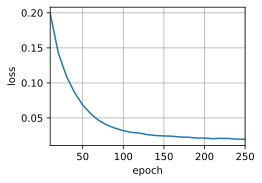

In [9]:
'''
正式训练开始
'''
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
# 也可以使用torch.device('cpu')
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

- 模型训练后，使用该模型将几个英语句子翻译成法语并计算它们的BLEU分数。


In [10]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [11]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

- 训练结束后，通过**可视化注意力权重**会发现，每个查询都会在键值对上分配不同的权重。
- 说明在每个解码步中，输入序列的不同部分被选择性地聚集在注意力池中。


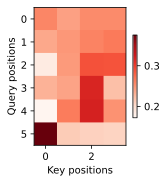

In [12]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## 小结

* 在预测词元时，如果不是所有输入词元都是相关的，那么具有Bahdanau注意力的循环神经网络编码器-解码器会有选择地统计输入序列的不同部分。这是通过将上下文变量视为加性注意力池化的输出来实现的。
* 在循环神经网络编码器-解码器中，Bahdanau注意力将上一时间步的解码器隐状态视为查询，在所有时间步的编码器隐状态同时视为键和值。